In [1]:
from segmenter_api.utils.file import get_project_dir

%cd {get_project_dir()}
print(get_project_dir())

/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api
/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api


In [15]:
from pathlib import Path

import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation

from segmenter_api.utils.image import resize_image_keep_aspect

In [ ]:
birefnet = AutoModelForImageSegmentation.from_pretrained(
    "zhengpeng7/BiRefNet", trust_remote_code=True
)

/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api/.venv/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


model.safetensors:   0%|          | 0.00/444M [00:00<?, ?B/s]

In [7]:
torch.set_float32_matmul_precision(["high", "highest"][0])
birefnet.to("cuda")
birefnet.eval()
birefnet.half()

BiRefNet(
  (bb): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=T

In [16]:
image_path = Path("data/multiple_products.png")
image = Image.open(image_path)
resized_image = resize_image_keep_aspect(img=image, long_size=1024).convert("RGB")
input_image = Image.new("RGB", (1024, 1024))
input_image.paste(resized_image)

In [19]:
transform_image = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

input_images = transform_image(input_image).unsqueeze(0).to("cuda").half()

# Prediction
with torch.no_grad():
    preds = birefnet(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(input_image.size)
input_image.putalpha(mask)


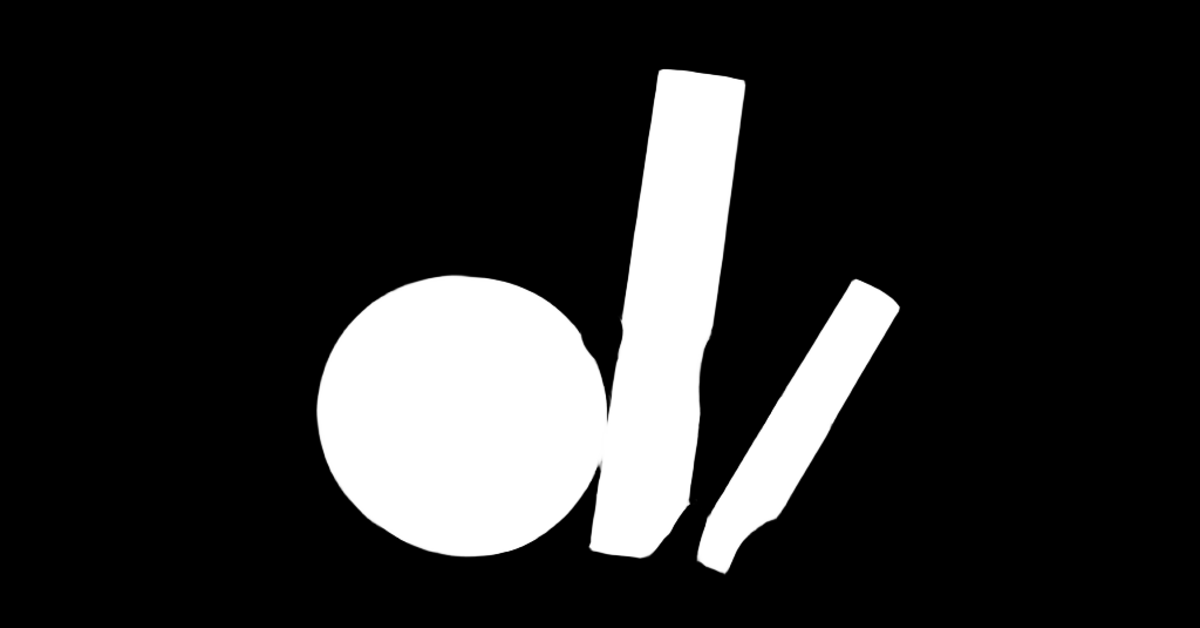

In [24]:
mask.crop((0, 0, resized_image.size[0], resized_image.size[1])).resize(image.size)